In [1]:
%pip install numpy
%pip install matplotlib
%pip install pandas

You should consider upgrading via the '/Users/gavriloilic/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/gavriloilic/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/gavriloilic/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

NUM_GENERATIONS = 500
MUTATION_PROB = 0.1

DEPOT = (50, 50)

X_RANGE = (0, 100)
Y_RANGE = (0, 100)

# --- Helper Functions ---
def euclidean_distance(p1, p2):
    """Calculate Euclidean distance between two points."""
    return math.hypot(p1[0] - p2[0], p1[1] - p2[1])


def calculate_distance_matrix(locations):
    """Precompute pairwise distances between all locations."""
    N = len(locations)
    distance_matrix = [[0.0 for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            distance_matrix[i][j] = euclidean_distance(locations[i], locations[j])

    return distance_matrix



# --- Genetic Algorithm Components ---
def create_individual(num_customers, num_vehicles):
    """Random initial distribution: allow some routes to remain empty."""
    customers = list(range(1, num_customers + 1))
    random.shuffle(customers)

    routes = [[] for _ in range(num_vehicles)]
    for customer in customers:
      routes[random.randint(0, num_vehicles - 1)].append(customer)

    # Add depot as start and end points for each vehicle route; otherwise [0,0]
    return [[0] + route + [0] if route else [0, 0] for route in routes]



def solution_distance(solution, distance_matrix):
    """Compute total distance of all routes in a solution."""
    total = 0.0
    for route in solution:
      if len(route) > 2: # Skip empty [0, 0] routes
          for i in range(len(route) - 1):
              total += distance_matrix[route[i]][route[i+1]]

    return total


# Used ChatGPT to adjust the crossover for the Vehicle Routing Problem
def crossover(parent1, parent2, num_vehicles, pc=0.8):
    """Route-based crossover that can produce empty routes."""

    #With probability (1 - pc), skip crossover and just return a copy of a parent
    if random.random() > pc:
        return [route[:] for route in parent1]

    child = [[] for _ in range(num_vehicles)]
    # Randomly choose a number of routes to take from parent1
    chosen_routes = random.sample(range(num_vehicles), k=random.randint(1, num_vehicles))
    assigned = set()

    for i in chosen_routes:
      child[i] = parent1[i][1:-1] # Customers only, i.e. skip start and end depot
      assigned.update(child[i])


    # Get all customers from parent2 that haven't already been assigned
    unassigned_customers = []
    for route in parent2:
      for customer in route[1:-1]:  # skip depot at start and end
        if customer not in assigned:
          unassigned_customers.append(customer)

    # Try to assign these customers to child routes,
    # roughly matching the length of the routes in parent2
    customer_index = 0
    for vehicle_index in range(num_vehicles):
        target_length = len(parent2[vehicle_index]) - 2  # exclude depot
        while (customer_index < len(unassigned_customers) and
              len(child[vehicle_index]) < target_length):
            customer = unassigned_customers[customer_index]
            child[vehicle_index].append(customer)
            customer_index += 1



    return [[0] + route + [0] if route else [0, 0] for route in child]



def tournament_selection(population, distance_matrix, k=3):
    """Select one solution via tournament selection."""
    candidates = random.sample(population, k)
    #print(f"Tournament: {tournament}")
    return min(candidates, key=lambda x: solution_distance(x, distance_matrix))


# Used ChatGPT to optimize the mutation for VRP
def mutate(solution, mutation_prob):
    """Move customer between routes (possibly emptying one route)."""
    if random.random() > mutation_prob:
        return solution

    new_solution = [route[:] for route in solution]
    non_epmty = [i for i, route in enumerate(new_solution) if len(route) > 2]
    if not non_epmty:
      return new_solution

    src = random.choice(non_epmty)
    dst = random.choice([i for i in range(len(new_solution)) if i != src])


    i = random.randint(1, len(new_solution[src]) - 2)
    customer = new_solution[src].pop(i)

    insert_pos = random.randint(1, len(new_solution[dst]) -1)
    new_solution[dst].insert(insert_pos, customer)
    return new_solution


# --- Main Genetic Algorithm ---
def genetic_algorithm(distance_matrix, num_customers, pop_size=20, num_vehicles=3, generations=300, mutation_prob=0.1, tournament_size=3):
    """Run a genetic algorithm for vehicle routing problem."""
    population = [create_individual(num_customers, num_vehicles) for _ in range(pop_size)]
    all_histories = []

    for gen in range(generations):
        population.sort(key=lambda s: solution_distance(s, distance_matrix))
        best_distance = solution_distance(population[0], distance_matrix)
        all_histories.append(best_distance)
        #print(f"Generation {gen}: Best Distance = {best_distance:.2f}")

        new_population = []
        while len(new_population) < pop_size:
            p1 = tournament_selection(population, distance_matrix, tournament_size)
            p2 = tournament_selection(population, distance_matrix, tournament_size)
            c1, c2 = crossover(p1, p2, num_vehicles), crossover(p2, p1, num_vehicles)

            c1 = mutate(c1, mutation_prob)
            c2 = mutate(c2, mutation_prob)
            new_population.append(c1)
            if len(new_population) < pop_size:
                new_population.append(c2)

        # Elitism; Keep the best from current population
        population = [population[0]] + new_population[:-1]


    best_solution = min(population, key=lambda s: solution_distance(s, distance_matrix))
    best_solution = [r for r in best_solution if len(r) > 2]
    return best_solution, solution_distance(best_solution, distance_matrix), all_histories



def run_experiment(generations, mutation_prob, distance_matrix, num_runs=20):
    results = {}
    best_routes= []
    all_histories = []
    best_solution_overall = None
    best_distance_overall = float('inf')
    for _ in range(num_runs):
        best_solution, best_distance, history = genetic_algorithm(
        distance_matrix,
        num_customers=NUM_CUSTOMERS,
        num_vehicles=NUM_VEHICLES,
        pop_size=NUM_CUSTOMERS,
        generations=NUM_GENERATIONS,
        mutation_prob=MUTATION_PROB
        )
        best_routes.append(best_distance)
        all_histories.append(history)

        if best_distance < best_distance_overall:
            best_distance_overall = best_distance
            best_solution_overall = best_solution

    avg_history = np.mean(all_histories, axis=0)
    results = {
        "best": min(best_routes),
        "worst": max(best_routes),
        "mean": np.mean(best_routes),
        "std_dev": np.std(best_routes),
        "avg_best_fitness": avg_history
    }

    print(f"Statistics for Population Size {NUM_CUSTOMERS}")
    print(f"Best: {min(best_routes):.2f}, Worst: {max(best_routes):.2f}, Mean: {np.mean(best_routes):.2f}, Std Dev: {np.std(best_routes):.2f}\n")

    return results, best_solution_overall


def plot_route(solution, locations):
    plt.figure(figsize=(10, 8))
    for vehicle_idx, route in enumerate(solution):
        route_coords = [locations[i] for i in route]
        xs, ys = zip(*route_coords)
        plt.plot(xs, ys, marker='o', label=f"Vehicle {vehicle_idx + 1}")


        print(f"Vehicle {vehicle_idx + 1}: " + " -> ".join(map(str, route)))

    plt.scatter(*DEPOT, color='red', s=100, label='Depot')
    for i, (x, y) in enumerate(locations[1:], start=1):
        plt.text(x, y, f"C{i}", fontsize=9)

    plt.title("Best Route for Vehicles")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
customers_small_1 = [(15, 23), (48, 55), (1, 54), (37, 63), (83, 45), (99, 93), (38, 32), (12, 22), (79, 49), (26, 24), (87, 31), (13, 73), (90, 74), (66, 61), (75, 71), (69, 5), (78, 11), (45, 88), (65, 99), (6, 31)]
customers_small_2 = [(52, 36), (92, 81), (3, 96), (40, 77), (83, 66), (74, 0), (19, 53), (80, 36), (77, 42), (86, 94), (67, 67), (34, 24), (20, 29), (84, 4)]
customers_medium_1 = [(49, 24), (29, 78), (0, 97), (63, 2), (52, 96), (96, 34), (63, 78), (45, 75), (13, 63), (76, 87), (7, 75), (53, 22), (93, 89), (1, 23), (30, 86), (25, 90)]
customer_medium_2 = [(70, 86), (51, 54), (51, 41), (78, 90), (11, 21), (42, 38), (47, 88), (33, 78), (14, 2), (44, 42), (91, 20), (46, 51), (88, 41), (92, 59), (2, 83), (58, 1), (88, 20), (93, 65), (84, 61), (29, 14), (94, 29), (43, 83), (56, 61), (21, 18), (83, 72), (76, 96), (58, 91)]
customer_large_1 = [(27, 95), (24, 97), (91, 79), (79, 76), (2, 76), (58, 34), (6, 75), (36, 66), (23, 8), (54, 59), (22, 53), (64, 20), (39, 0), (50, 95), (10, 76), (88, 85), (49, 12), (97, 36), (76, 94), (83, 59), (16, 63), (99, 85), (30, 8), (82, 84), (71, 1), (80, 40), (21, 97), (2, 34), (53, 82), (58, 47), (99, 65), (15, 43), (0, 14), (19, 4), (54, 76), (90, 100)]
customer_large_2 = [(92, 92), (98, 9), (65, 71), (77, 96), (5, 75), (25, 8), (6, 64), (30, 32), (6, 65), (51, 9), (1, 22), (90, 63), (94, 17), (20, 45), (70, 79), (74, 69), (31, 93), (30, 36), (82, 41), (67, 87), (26, 55), (17, 63), (80, 20), (57, 71), (79, 94), (17, 86), (87, 57), (81, 32), (9, 61), (51, 89), (41, 94), (71, 83), (68, 0), (53, 8), (98, 71), (59, 40), (24, 50), (97, 25), (3, 73), (72, 97), (61, 68), (7, 11), (24, 63), (46, 27), (12, 20), (80, 2), (34, 100), (39, 74), (55, 41)]

vehicles_small_1 = 7
vehicles_small_2 = 3
vehicles_medium_1 = 14
vehicles_medium_2 = 23
vehicles_large_1 = 29
vehicles_large_2 = 45





--- Running Scenario: Small 1 ---
Statistics for Population Size 20
Best: 474.52, Worst: 703.76, Mean: 570.80, Std Dev: 47.03

Best Distance for Small 1: 474.52
Vehicle 1: 0 -> 7 -> 1 -> 10 -> 8 -> 20 -> 3 -> 12 -> 0
Vehicle 2: 0 -> 9 -> 5 -> 11 -> 17 -> 16 -> 0
Vehicle 3: 0 -> 2 -> 4 -> 18 -> 19 -> 6 -> 13 -> 15 -> 14 -> 0


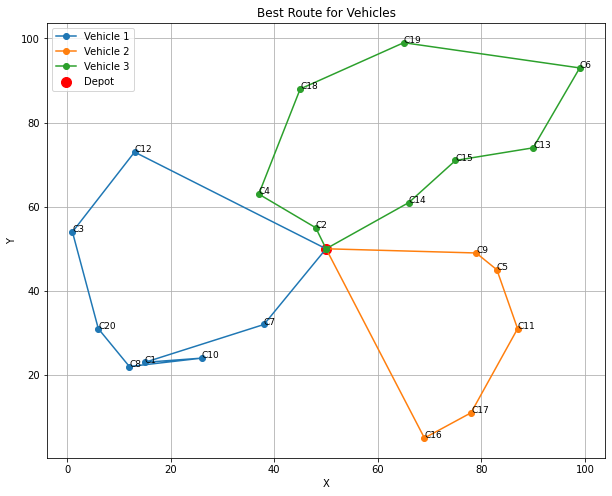


--- Running Scenario: Small 2 ---
Statistics for Population Size 14
Best: 434.50, Worst: 564.47, Mean: 476.40, Std Dev: 28.64

Best Distance for Small 2: 434.50
Vehicle 1: 0 -> 1 -> 12 -> 13 -> 7 -> 3 -> 4 -> 0
Vehicle 2: 0 -> 8 -> 9 -> 6 -> 14 -> 5 -> 2 -> 10 -> 11 -> 0


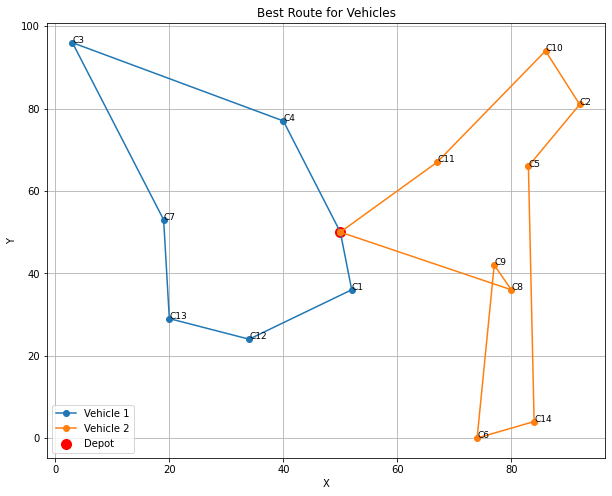


--- Running Scenario: Medium 1 ---
Statistics for Population Size 16
Best: 527.91, Worst: 668.26, Mean: 623.68, Std Dev: 30.90

Best Distance for Medium 1: 527.91
Vehicle 1: 0 -> 6 -> 4 -> 1 -> 12 -> 0
Vehicle 2: 0 -> 8 -> 2 -> 15 -> 16 -> 3 -> 11 -> 9 -> 14 -> 0
Vehicle 3: 0 -> 5 -> 7 -> 10 -> 13 -> 0


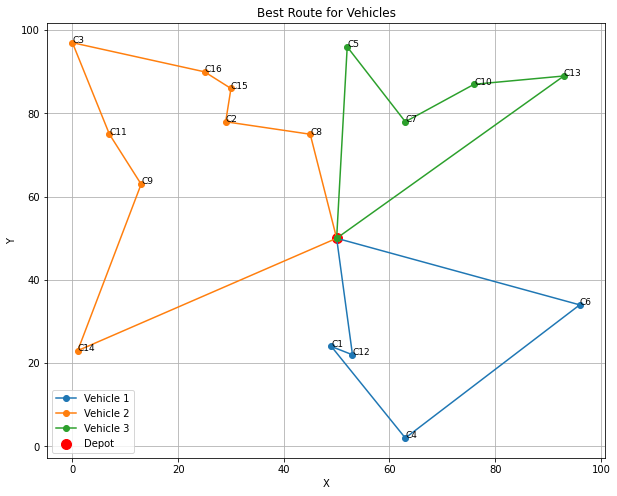


--- Running Scenario: Medium 2 ---
Statistics for Population Size 27
Best: 692.12, Worst: 888.49, Mean: 777.83, Std Dev: 48.62

Best Distance for Medium 2: 692.12
Vehicle 1: 0 -> 24 -> 20 -> 9 -> 5 -> 6 -> 10 -> 0
Vehicle 2: 0 -> 8 -> 15 -> 12 -> 0
Vehicle 3: 0 -> 22 -> 7 -> 1 -> 19 -> 14 -> 18 -> 0
Vehicle 4: 0 -> 23 -> 25 -> 4 -> 26 -> 27 -> 2 -> 0
Vehicle 5: 0 -> 13 -> 21 -> 11 -> 17 -> 16 -> 3 -> 0


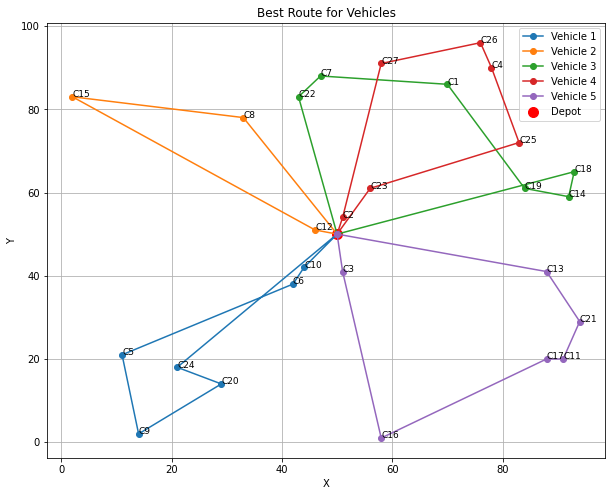


--- Running Scenario: Large 1 ---
Statistics for Population Size 36
Best: 1010.27, Worst: 1233.33, Mean: 1123.81, Std Dev: 56.00

Best Distance for Large 1: 1010.27
Vehicle 1: 0 -> 11 -> 32 -> 5 -> 7 -> 15 -> 21 -> 0
Vehicle 2: 0 -> 22 -> 3 -> 24 -> 16 -> 4 -> 20 -> 0
Vehicle 3: 0 -> 18 -> 31 -> 36 -> 19 -> 29 -> 35 -> 10 -> 0
Vehicle 4: 0 -> 8 -> 2 -> 27 -> 1 -> 14 -> 0
Vehicle 5: 0 -> 30 -> 26 -> 6 -> 0
Vehicle 6: 0 -> 34 -> 23 -> 17 -> 13 -> 25 -> 12 -> 0
Vehicle 7: 0 -> 9 -> 33 -> 28 -> 0


In [ ]:
# Define all scenarios
scenarios = [
    {"name": "Small 1", "customers": customers_small_1, "vehicles": vehicles_small_1},
    {"name": "Small 2", "customers": customers_small_2, "vehicles": vehicles_small_2},
    {"name": "Medium 1", "customers": customers_medium_1, "vehicles": vehicles_medium_1},
    {"name": "Medium 2", "customers": customer_medium_2, "vehicles": vehicles_medium_2},
    {"name": "Large 1", "customers": customer_large_1, "vehicles": vehicles_large_1},
    {"name": "Large 2", "customers": customer_large_2, "vehicles": vehicles_large_2}
]

# Store results for all scenarios
all_results = {}

for scenario in scenarios:
    name = scenario["name"]
    customers = scenario["customers"]
    num_vehicles = scenario["vehicles"]

    print(f"\n--- Running Scenario: {name} ---")

    locations = [DEPOT] + customers
    distance_matrix = calculate_distance_matrix(locations)
    NUM_CUSTOMERS = len(customers)
    NUM_VEHICLES = num_vehicles

    results, best_solution = run_experiment(NUM_GENERATIONS, MUTATION_PROB, distance_matrix)

    all_results[name] = {
        "results": results,
        "best_solution": best_solution,
        "locations": locations
    }

    print(f"Best Distance for {name}: {results['best']:.2f}")

    # Optional: plot best routes
    plot_route(best_solution, locations)


In [ ]:
# Prepare table data
table_data = []

for name, data in all_results.items():
    res = data["results"]
    table_data.append({
        "Scenario": name,
        "Best Distance": round(res["best"], 2),
        "Worst Distance": round(res["worst"], 2),
        "Mean Distance": round(res["mean"], 2),
        "Std Dev": round(res["std_dev"], 2)
    })

# Create a DataFrame for a neat table
results_table = pd.DataFrame(table_data)

# Shift index to start from 1
results_table.index = results_table.index + 1

# Display the table
print("\n--- Summary Table of VRP Scenarios ---")
print(results_table)